<a href="https://colab.research.google.com/github/AaliyahLusianti074/Machine-learning/blob/main/Model_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive._mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/My Drive"

 asl-flask			   'Banner Aliyah.cdr'	 Kaggle
'Banner Aliyah 2.5 x 1 meter.jpg'  'Colab Notebooks'	'Semester 7'


In [ ]:
!unzip -q "/content/gdrive/My Drive/Semester 7/Pembelajaran Mesin/Dataset ASL/archive.zip"

In [ ]:
import pandas
import numpy as np
import pandas as pd
import os
import keras
from pathlib import Path
import os.path
import tensorflow as tf
from keras import utils as np_utils 
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import regularizers
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from time import perf_counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display
def printmd(string):   
    display(Markdown(string))

In [ ]:
dir_ = Path('asl_alphabet_train/asl_alphabet_train')
file_paths = list(dir_.glob(r'**/*.jpg'))

In [ ]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)

    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(file_paths)

print(f'Number of pictures in the dataset: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

df.head(5)

Number of pictures in the dataset: 87000

Number of different labels: 29

Labels: ['R' 'D' 'nothing' 'U' 'Q' 'Z' 'G' 'N' 'L' 'H' 'space' 'E' 'W' 'M' 'J' 'B'
 'V' 'F' 'C' 'K' 'Y' 'I' 'S' 'del' 'T' 'X' 'P' 'O' 'A']


,Filepath,Label
0,asl_alphabet_train/asl_alphabet_train/R/R675.jpg,R
1,asl_alphabet_train/asl_alphabet_train/D/D2447.jpg,D
2,asl_alphabet_train/asl_alphabet_train/nothing/...,nothing
3,asl_alphabet_train/asl_alphabet_train/U/U2777.jpg,U
4,asl_alphabet_train/asl_alphabet_train/Q/Q196.jpg,Q


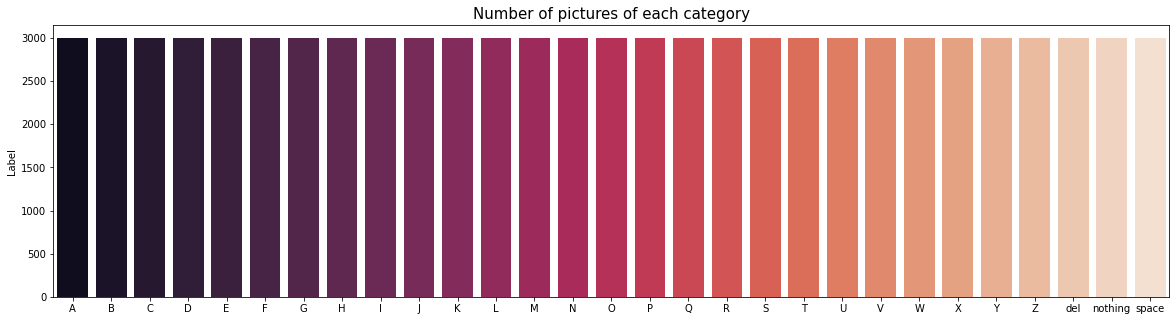

In [ ]:
vc = df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

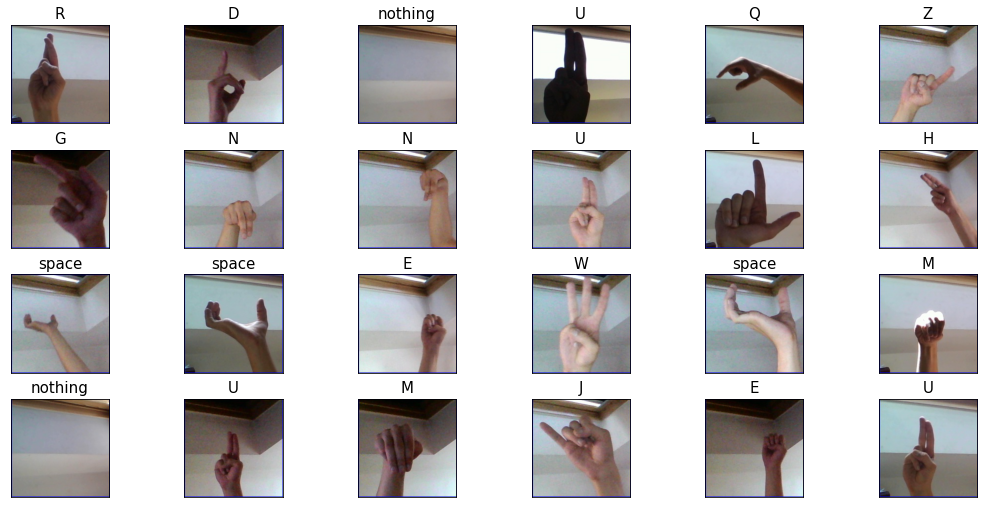

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
train_df, test_df = train_test_split(df.sample(frac = 0.05), test_size=0.1, random_state=0)

In [ ]:
def create_gen():
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',

    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',

    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [ ]:
def get_model(model):
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(29, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "EfficientNetB2": {"model":tf.keras.applications.EfficientNetB2, "perf":0},
    "EfficientNetB3": {"model":tf.keras.applications.EfficientNetB3, "perf":0},
    "EfficientNetB4": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB5": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB6": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB7": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
    "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

for name, model in models.items():
    
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()

    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 3524 validated image filenames belonging to 29 classes.
Found 391 validated image filenames belonging to 29 classes.
Found 435 validated image filenames belonging to 29 classes.


29097984/29084464 [==============================] - 0s 0us/step
DenseNet121          trained in 29.12 sec
51888128/51877672 [==============================] - 1s 0us/step
DenseNet169          trained in 24.81 sec
74850304/74836368 [==============================] - 1s 0us/step
DenseNet201          trained in 30.54 sec
16719872/16705208 [==============================] - 0s 0us/step
EfficientNetB0       trained in 15.44 sec
27033600/27018416 [==============================] - 0s 0us/step
EfficientNetB1       trained in 19.64 sec
31801344/31790344 [==============================] - 0s 0us/step
EfficientNetB2       trained in 20.24 sec
43950080/43941136 [==============================] - 0s 0us/step
EfficientNetB3       trained in 25.76 sec
71696384/71686520 [==============================] - 1s 0us/step


In [ ]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,val_accuracy,Training time (sec)
0,ResNet50V2,0.8107,15.04
1,MobileNetV2,0.7928,12.37
2,DenseNet169,0.7698,24.81
3,DenseNet201,0.7468,30.54
4,Xception,0.7136,20.72
5,DenseNet121,0.6777,29.12
6,NASNetMobile,0.5678,26.07
7,InceptionV3,0.5320,15.71
8,InceptionResNetV2,0.4859,34.83
9,VGG19,0.2788,19.09


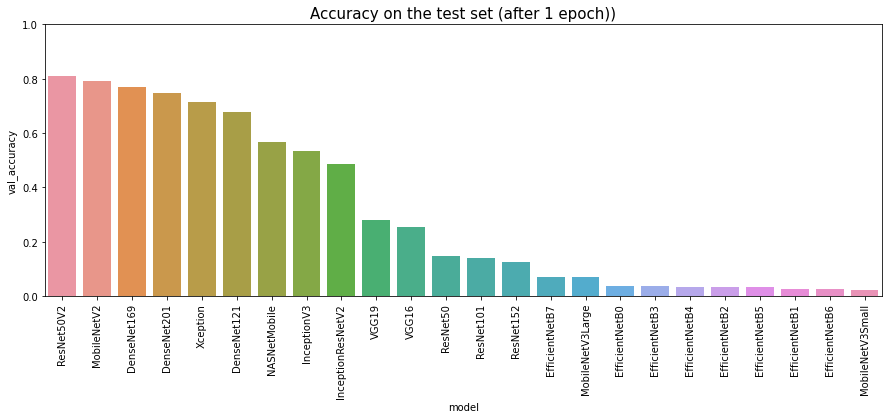

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'val_accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

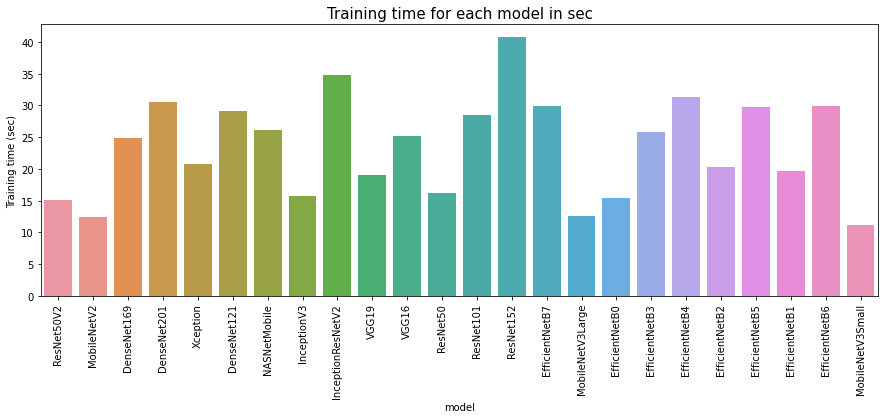

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
plt.xticks(rotation=90)
plt.show()

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=0)

train_generator,test_generator,train_images,val_images,test_images=create_gen()

best_model = df_results.iloc[0]

model = get_model( eval("tf.keras.applications."+ best_model[0]) )

history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=90,
                  
                    )

Found 70470 validated image filenames belonging to 29 classes.
Found 7830 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.
Epoch 1/90
2203/2203 [==============================] - 232s 104ms/step - loss: 0.2318 - accuracy: 0.9302 - val_loss: 0.0526 - val_accuracy: 0.9833
Epoch 2/90
2203/2203 [==============================] - 220s 100ms/step - loss: 0.0542 - accuracy: 0.9822 - val_loss: 0.0713 - val_accuracy: 0.9752
Epoch 3/90
2203/2203 [==============================] - 220s 100ms/step - loss: 0.0389 - accuracy: 0.9875 - val_loss: 0.0560 - val_accuracy: 0.9829
Epoch 4/90
2203/2203 [==============================] - 220s 100ms/step - loss: 0.0339 - accuracy: 0.9891 - val_loss: 0.0692 - val_accuracy: 0.9803
Epoch 5/90
2203/2203 [==============================] - 221s 100ms/step - loss: 0.0312 - accuracy: 0.9900 - val_loss: 0.0573 - val_accuracy: 0.9844
Epoch 6/90
2203/2203 [==============================] - 220s 100ms/step -

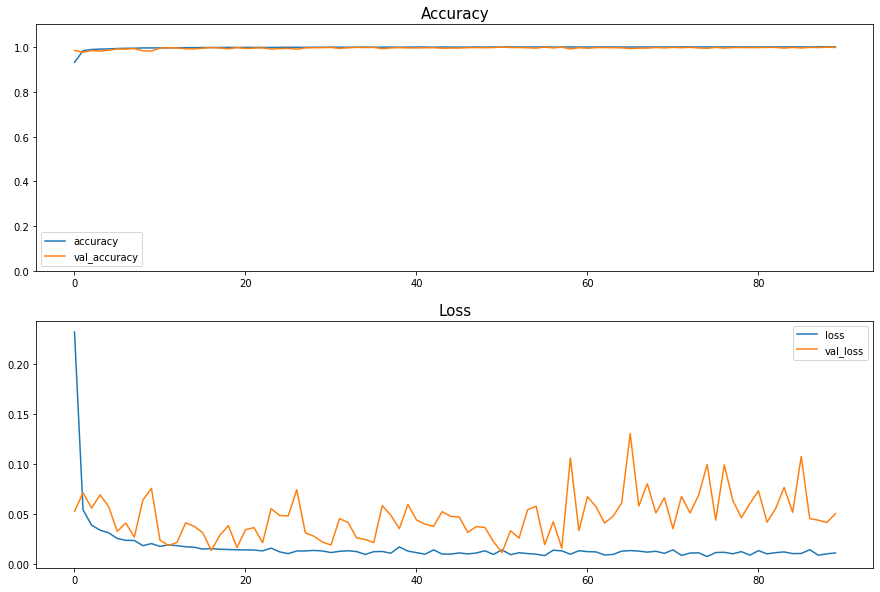

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

In [ ]:
plt.savefig('plot.svg')  

<Figure size 432x288 with 0 Axes>

## Best Model: ResNet50V2 with 99.61% accuracy on the test set

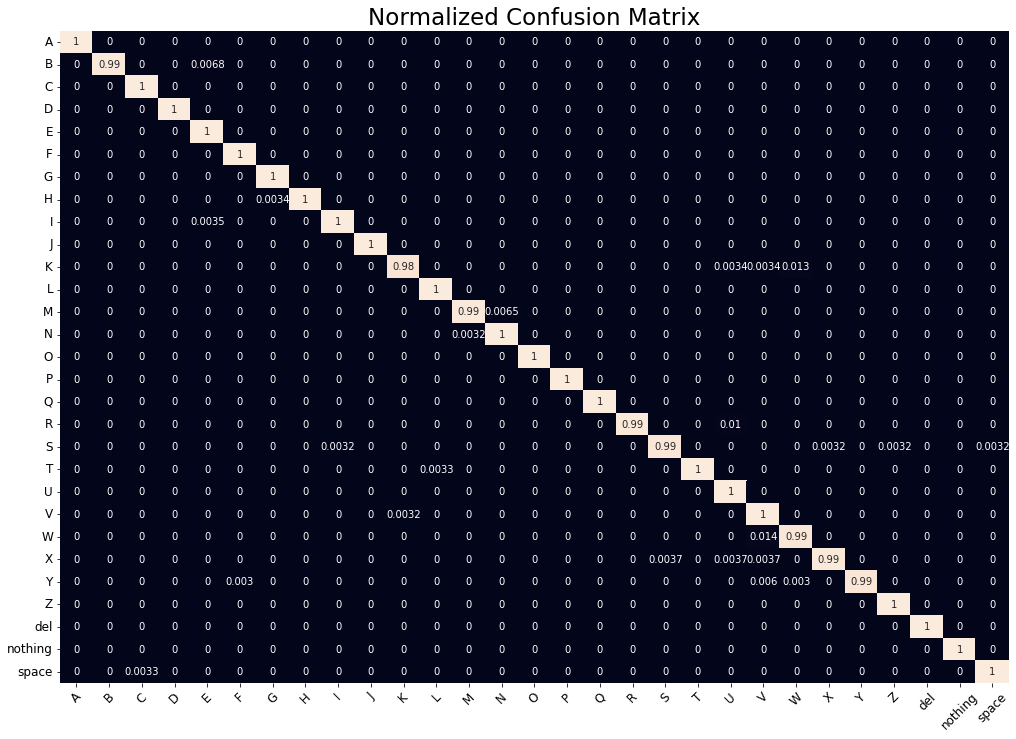

In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)

printmd(f'## Best Model: {best_model[0]} with {acc*100:.2f}% accuracy on the test set')

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (17,12))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=12,rotation=45)
plt.yticks(fontsize=12)
plt.show()

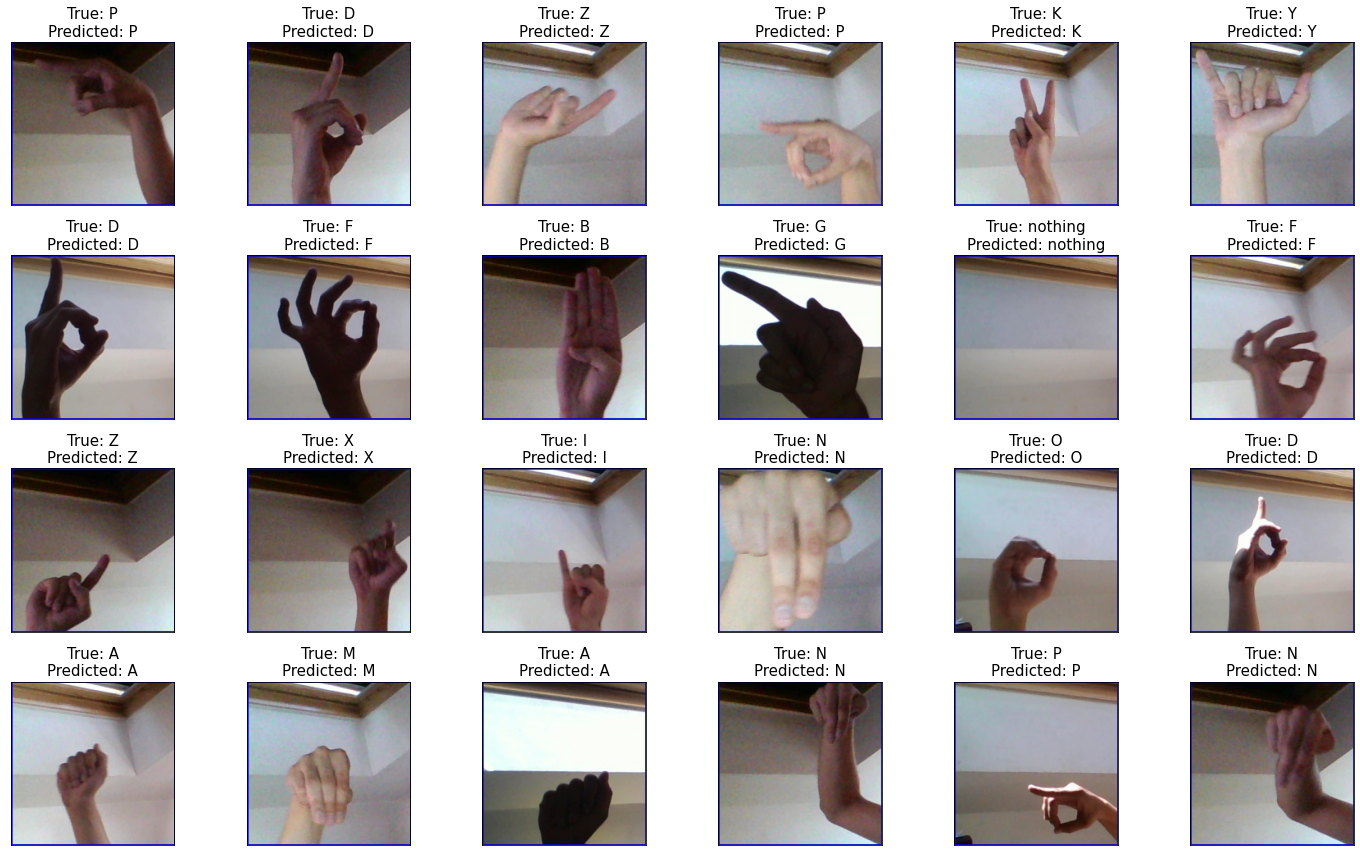

In [ ]:
# Display picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()

In [ ]:
model.save('modelMobileNet.h5')

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)

In [ ]:
converter_model = tf.lite.TFLiteConverter.from_keras_model(model) 
tflite_model = converter_model.convert()

INFO:tensorflow:Assets written to: /tmp/tmpue24rejq/assets


In [ ]:
with open('modelMobileNet.tflite', 'wb') as f: 
  f.write(tflite_model)